# Домашнее задание: линейная регрессия

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Сперва загрузим датасет в Python

In [44]:
data = pd.read_csv('Fish.csv')
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Данный датасет представляет собой набор данных о рыбном маркете, где каждый объект соответствует одной отдельной рыбе и ее характеристикам (вид, вес, длина, высота, ширина).

Данный датасет взять с [Kaggle](https://www.kaggle.com/datasets/vipullrathod/fish-market/data). Оттуда же можно взять подробное описание всех признаков в датасете.

>The fish market dataset is a collection of data related to various species of fish and their characteristics. This dataset is designed for polynomial regression analysis and contains several columns with specific information. Here's a description of each column in the dataset:

>Species: This column represents the species of the fish. It is a categorical variable that categorizes each fish into one of seven species. The species may include names like "Perch," "Bream," "Roach," "Pike," "Smelt," "Parkki," and "Whitefish." This column is the target variable for the polynomial regression analysis, where we aim to predict the fish's weight based on its other attributes.

>Weight: This column represents the weight of the fish. It is a numerical variable that is typically measured in grams. The weight is the dependent variable we want to predict using polynomial regression.

>Length1: This column represents the first measurement of the fish's length. It is a numerical variable, typically measured in centimetres.

>Length2: This column represents the second measurement of the fish's length. It is another numerical variable, typically measured in centimetres.

>Length3: This column represents the third measurement of the fish's length. Similar to the previous two columns, it is a numerical variable, usually measured in centimetres.

>Height: This column represents the height of the fish. It is a numerical variable, typically measured in centimetres.

>Width: This column represents the width of the fish. Like the other numerical variables, it is also typically measured in centimetres.

>The dataset is structured in such a way that each row corresponds to a single fish with its species and various physical measurements (lengths, height, and width). The goal of using polynomial regression on this dataset would be to build a predictive model that can estimate the weight of a fish based on its species and the provided physical measurements. Polynomial regression allows for modelling more complex relationships between the independent variables (lengths, height, and width) and the dependent variable (weight), which may be particularly useful if there are non-linear patterns in the data.

Мы решаем задачу прогнозирования веса рыбы по ее характеристикам.

## Предварительный анализ данных

Посмотрим, есть ли пропущенные значения в датасете

In [45]:
data.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

> Какие выводы можно сделать о пропущенных значениях? Нужно ли заполнять пропущенные значения? Если нужно, то как?

Нет пропусков в данных

Рассмотрим таблицу описательных статистик для датасета

In [46]:
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


> Какие средние значения для каждого признака? Какие среднеквадратичные отклонения? Какие максимальные и минимальные значения?

In [47]:
mean_row = data.describe().loc['mean']
pd.DataFrame(mean_row)

,mean
Weight,398.326415
Length1,26.247170
Length2,28.415723
Length3,31.227044
Height,8.970994
Width,4.417486


In [48]:
std_row = data.describe().loc['std']
pd.DataFrame(std_row)

,std
Weight,357.978317
Length1,9.996441
Length2,10.716328
Length3,11.610246
Height,4.286208
Width,1.685804


In [49]:
max_row = data.describe().loc['max']
pd.DataFrame(max_row)

,max
Weight,1650.000
Length1,59.000
Length2,63.400
Length3,68.000
Height,18.957
Width,8.142


In [50]:
min_row = data.describe().loc['min']
pd.DataFrame(min_row)

,min
Weight,0.0000
Length1,7.5000
Length2,8.4000
Length3,8.8000
Height,1.7284
Width,1.0476


В данном наборе данных присутствует некоторая особенность -- неоднородность данных. То есть интуитивно все данные можно разбить группы по видам рыб. Интуитивно мы понимаем, что у каждого вида будут схожие характеристики между собой. Однако они могут различаться между видами.

Сперва рассмотрим, насколько сбалансированы данные по каждому виду рыбы

In [51]:
data['Species'].value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

В группах сильный дисбаланс. Поэтому зависимость таргета Weight с остальными признаками мы будем рассматривать отдельно для каждого вида рыбы, чтобы ничего не упустить.

Определим зависимый и независимые признаки и запишем названия этих столбцов в отдельные переменные (пока что Species не считает признаком, поскольку сейчас мы будем рассматривать характеристики для каждого конкретного вида)

In [52]:
features = ['Length1', 'Length2', 'Length3', 'Height', 'Width']
target = 'Weight'

Также все возможные виды рыб запишем в отдельную переменную

In [53]:
species = data['Species'].unique().tolist()
species

['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt']

С помощью библиотеки Plotly построим диаграммы рассеяния по видам рыб каждой фичи с таргетом

In [54]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

for feature in features:
    fig = make_subplots(rows=1, cols=7, subplot_titles=species, x_title=feature, y_title=target)

    for i, specie in enumerate(species, start=1):
        col = (i % 7) + 1

        filtered_data = data[data['Species'] == specie]

        scatter_trace = go.Scatter(
            x=filtered_data[feature],
            y=filtered_data[target],
            mode='markers',
            name=specie
        )

        fig.add_trace(scatter_trace, row=1, col=col)

    fig.update_layout(height=300, width=1300)
    fig.show()

> Какие выводы о взаимосвязях между фичами и таргетом можно сделать? Сказывается ли неоднородность в данных на взаимосвязях?

Для всех видов рыбы вес примерно линейно зависит от этих параметров 

Также рассмотрим соответствующие гистограммы распределений

In [55]:
variables = [feature for feature in features]
variables.append(target)
variables

['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Weight']

In [56]:
for variable in variables:
    fig = make_subplots(rows=1, cols=7, subplot_titles=species, x_title=variable, y_title='Count')

    for i, specie in enumerate(species, start=0):
        col = (i % 7) + 1

        filtered_data = data[data['Species'] == specie]

        histogram_trace = go.Histogram(
            x=filtered_data[variable],
            name=specie,
            marker=dict(color=px.colors.qualitative.Set1[i % len(px.colors.qualitative.Set1)]),
            showlegend=False
        )

        fig.add_trace(histogram_trace, row=1, col=col)

    fig.update_layout(
        height=300,
        width=1300,
        bargap=0.2,
    )
    fig.show()

> Какие выводы можно сделать о распределениях? Схожи ли они между собой? Схожи ли они с нормальным распределением?

> Есть ли какие-то специфики между видами рыб для распределений Weight?

Теперь попробуем объединить всё в одну матрицу диаграмм рассеяния и сравнить с предыдущими выводами

Weight для всех видов рыб распределен логнормально. Если виды рыб, которые намного тяжелее остальных.

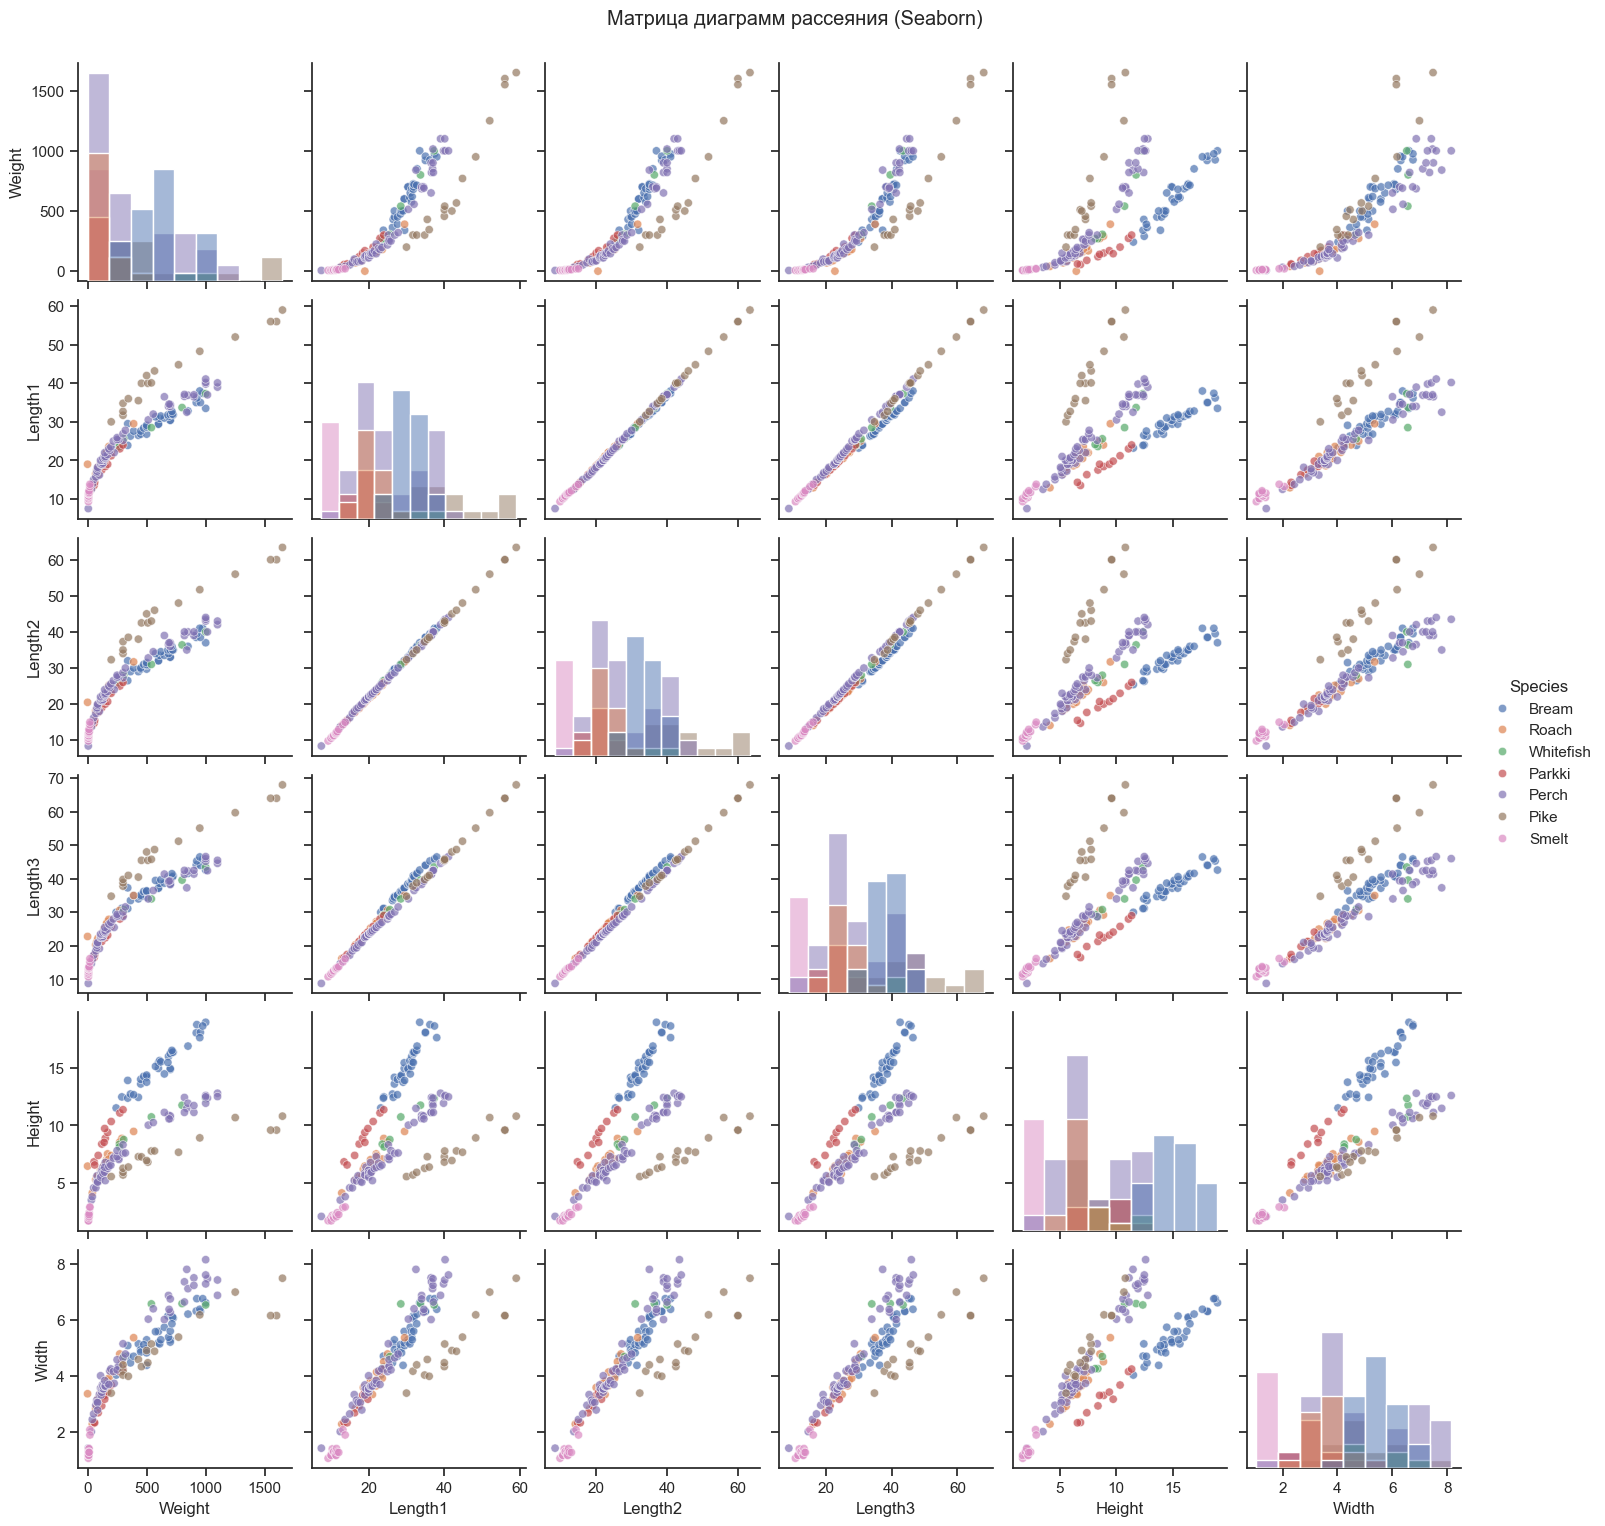

In [57]:
sns.set(style="ticks")
sns.pairplot(
    data,
    hue='Species', 
    vars=['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width'],
    diag_kind='hist',
    markers='o',      
    plot_kws={'alpha': 0.7}
)
plt.suptitle('Матрица диаграмм рассеяния (Seaborn)', y=1.02)
plt.show()

> Сильно ли изменились результаты? Если да, то для каких конкретно переменных?

Проверим гипотезы о нормальном распределении

In [58]:
from scipy.stats import kstest, norm, pearsonr

for column in data[variables]:

    random_variable = data[column]

    mean = np.mean(random_variable)
    std = np.std(random_variable)
    theoretical_distribution = norm(loc=mean, scale=std)

    statistic, p_value = kstest(random_variable, theoretical_distribution.cdf)

    print(f"Значения параметров нормального распределения случайной величины {column}: {mean}, {std}")
    print(f"P-значение: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Гипотеза о нормальном распределении {column} отклоняется.")
    else:
        print(f"Гипотеза о нормальном распределении {column} принимается.")

    print('\n')

Значения параметров нормального распределения случайной величины Length1: 26.247169811320756, 9.964956278140518
P-значение: 0.3959225403554635
Гипотеза о нормальном распределении Length1 принимается.


Значения параметров нормального распределения случайной величины Length2: 28.415723270440253, 10.68257580056147
P-значение: 0.4142428388716072
Гипотеза о нормальном распределении Length2 принимается.


Значения параметров нормального распределения случайной величины Length3: 31.227044025157234, 11.573678038449335
P-значение: 0.3435162793586344
Гипотеза о нормальном распределении Length3 принимается.


Значения параметров нормального распределения случайной величины Height: 8.970993710691824, 4.2727077199165695
P-значение: 0.016236686860181808
Гипотеза о нормальном распределении Height отклоняется.


Значения параметров нормального распределения случайной величины Width: 4.417485534591195, 1.6804942383152874
P-значение: 0.5949738743434563
Гипотеза о нормальном распределении Width принимае

Гипотеза о нормальном распределении была отклонена для `Height`, хотя значение достаточно близко к пороговому. Однако мы всё же будем считать, что `Height` распределена нормально. Поскольку из гистограмм видно, что проблемы могло вызвать лишь распределение `Height` для `Parkki`. Для остальных же видов рыб гистограммы схожи с "колоколом" нормального распределения.

Другая проблема у нас возникает с нашей целевой переменной -- `Weight`. Проверим гипотезу о нормальном распределении для каждого конкретного вида рыбы

In [59]:
for specie in species:

    random_variable = data[data['Species'] == specie][target]

    mean = np.mean(random_variable)
    std = np.std(random_variable)
    theoretical_distribution = norm(loc=mean, scale=std)

    statistic, p_value = kstest(random_variable, theoretical_distribution.cdf)

    print(f"Значения параметров нормального распределения случайной величины Weight для {specie}: {mean}, {std}")
    print(f"P-значение: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print(f"Гипотеза о нормальном распределении Weight для {specie} отклоняется.")
    else:
        print(f"Гипотеза о нормальном распределении Weight для {specie} принимается.")

    print('\n')

Значения параметров нормального распределения случайной величины Weight для Bream: 617.8285714285714, 206.19539771977531
P-значение: 0.6893969429054044
Гипотеза о нормальном распределении Weight для Bream принимается.


Значения параметров нормального распределения случайной величины Weight для Roach: 152.05, 86.57971760175705
P-значение: 0.5282414742066976
Гипотеза о нормальном распределении Weight для Roach принимается.


Значения параметров нормального распределения случайной величины Weight для Whitefish: 531.0, 282.6275523251994
P-значение: 0.6111373280441859
Гипотеза о нормальном распределении Weight для Whitefish принимается.


Значения параметров нормального распределения случайной величины Weight для Parkki: 154.8181818181818, 75.0900286102903
P-значение: 0.8919475578460732
Гипотеза о нормальном распределении Weight для Parkki принимается.


Значения параметров нормального распределения случайной величины Weight для Perch: 382.23928571428576, 344.500006571932
P-значение: 0.002

In [60]:
numeric_data = data.iloc[:, :-1].columns
numeric_data

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height'], dtype='object')

Таким образом, гипотеза отклоняется толкьо для `Perch`. Следовательно, вопреки отклонению гипотезы о нормальном распределении для неоднородного случая, мы будем считать, что целевая переменная Weight в целом распределена нормально.

Напоследок разберемся с истинной корреляцией. Рассмотрим гипотезу о нулевой корреляции между фичами и таргетом. Здесь мы будем рассматривать эти гипотезы для неоднородного случая (то есть не разделяя рыб по видам).

In [61]:
from scipy.stats import pearsonr

numeric_data = data.select_dtypes(include=['float64', 'int64'])

target = numeric_data['Weight'] 

for feature in numeric_data.columns.drop('Weight'): 
    statistic, p_value = pearsonr(numeric_data[feature], target)
    print(f"Признак: {feature}, p-значение: {p_value:.4f}")
    if p_value < 0.05:
        print("Корреляция статистически значима!")
    else:
        print("Корреляция не значима.")

Признак: Length1, p-значение: 0.0000
Корреляция статистически значима!
Признак: Length2, p-значение: 0.0000
Корреляция статистически значима!
Признак: Length3, p-значение: 0.0000
Корреляция статистически значима!
Признак: Height, p-значение: 0.0000
Корреляция статистически значима!
Признак: Width, p-значение: 0.0000
Корреляция статистически значима!


In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = numeric_data.drop('Weight', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

   feature           VIF
0  Length1  12782.535830
1  Length2  16598.744318
2  Length3   3380.815907
3   Height     76.064364
4    Width     92.658672


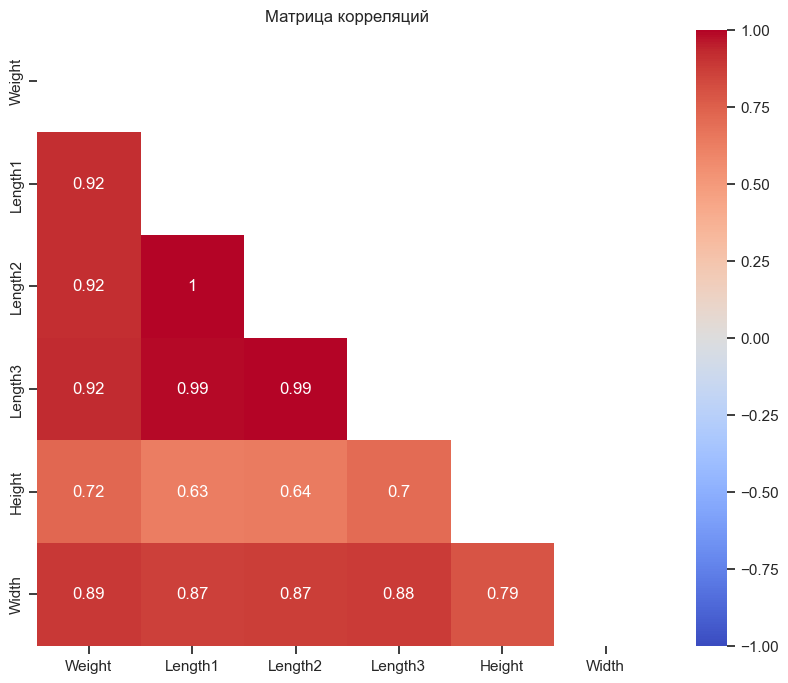

In [63]:
corr_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
mask=np.triu(corr_matrix) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask,vmin=-1, vmax=1)
plt.title("Матрица корреляций")
plt.show()

**В данных присутствует сильная корреляция признаков между собой (мультиколлинеарность)**

**оставим только Length1, так как Length2 и Length3 сильно коррелирую**

> Таким образом, для каких фичей мы можем считать корреляцию нулевой?

Исключим из data те фичи, для которых корреляция нулевая и построим корреляционную матрицу

In [67]:
# YOUR CODE
data.drop(['Length2', 'Length3'], axis=1)
# Hint: для исключения фичи (если нужно исключить) используйте data.drop
# Hint: для корреляционной матрицы используйте метод .corr() или визуализацию sns.heatmap
# Пример, как это делать, был рассмотрен в ноутбуке на семинаре

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340
...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936
155,Smelt,13.4,11.7,2.4300,1.2690
156,Smelt,12.2,12.1,2.2770,1.2558
157,Smelt,19.7,13.2,2.8728,2.0672


Перед построением модели у нас осталась одна последняя неразрешенная проблема: в нашем датасете присутствует категориальный текстовый признак Species. Нам нужно закодировать его с помощью чисел.
В качестве простейшего способа кодирования будем использовать One-Hot-Encoding

In [77]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore') 
encoded = encoder.fit_transform(data[['Species']])
species_encoded = pd.DataFrame.sparse.from_spmatrix(
    encoded,
    columns=encoder.get_feature_names_out(['Species'])
)
final_data = pd.concat([data.drop('Species', axis=1), species_encoded], axis=1)

In [78]:
final_data

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1.0,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1.0,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1.0,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1.0,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,0,1.0,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,0,1.0,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1.0,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,0,1.0,0


## Построение модели линейной регресии

Сперва обозначим всю выборку через $X$ (фичи) и $y$ (таргет)

In [80]:
X = final_data.drop(columns='Weight')
y = final_data['Weight']

Приведем $X$ и $y$ к стандартному виду (среднее = 0, среднеквадратичное отклонение = 1)

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)
y = scaler.fit_transform(pd.DataFrame(y))

c:\Users\Asus\anaconda3\envs\mykerenv\lib\site-packages\sklearn\utils\validation.py:921: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\Asus\anaconda3\envs\mykerenv\lib\site-packages\sklearn\utils\validation.py:921: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



In [89]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

Убедимся в том, что все данные были преобразованы как надо

In [88]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02,1.590000e+02
mean,-1.061345e-16,-1.452367e-16,-7.820439e-17,4.468822e-17,-2.793014e-16,1.787529e-16,-4.468822e-17,1.340647e-16,2.234411e-17,-4.468822e-17,8.937644e-17,-8.937644e-17
std,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00,1.003160e+00
min,-1.881310e+00,-1.873679e+00,-1.937763e+00,-1.695083e+00,-2.005294e+00,-5.312796e-01,-2.726249e-01,-7.373529e-01,-3.460033e-01,-3.793216e-01,-3.107277e-01,-1.980295e-01
25%,-7.222480e-01,-6.941887e-01,-6.978805e-01,-7.082613e-01,-6.140072e-01,-5.312796e-01,-2.726249e-01,-7.373529e-01,-3.460033e-01,-3.793216e-01,-3.107277e-01,-1.980295e-01
50%,-1.050852e-01,-1.044433e-01,-1.578620e-01,-2.773402e-01,-1.005570e-01,-5.312796e-01,-2.726249e-01,-7.373529e-01,-3.460033e-01,-3.793216e-01,-3.107277e-01,-1.980295e-01
75%,6.475523e-01,6.631618e-01,7.277683e-01,7.945562e-01,6.944472e-01,-5.312796e-01,-2.726249e-01,1.356203e+00,-3.460033e-01,-3.793216e-01,-3.107277e-01,-1.980295e-01
max,3.286801e+00,3.274892e+00,3.177292e+00,2.337161e+00,2.216321e+00,1.882248e+00,3.668044e+00,1.356203e+00,2.890146e+00,2.636285e+00,3.218252e+00,5.049752e+00


In [90]:
y.describe()

,0
count,1.590000e+02
mean,1.955110e-17
std,1.003160e+00
min,-1.116227e+00
25%,-7.799517e-01
50%,-3.512011e-01
75%,7.052627e-01
max,3.507554e+00


Разделим всю выборку на train и test наборы

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Теперь воспользуемся уже готовой реализацией модели линейной регрессии из библиотеки sklearn

In [93]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

Обучим модель на train выборке

In [94]:
lr.fit(X_train, y_train)

LinearRegression()

Рассмотрим значения метрик $MSE$ и $R^2$ на тестовом наборе

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_hat = lr.predict(X_train) # YOUR CODE
# Hint: вычислите прогнозы модели на обучающем наборе

train_mse = mean_squared_error(y_train, y_hat)
train_r2 = r2_score(y_train, y_hat)

print(f'Значение MSE на Train наборе {train_mse}')
print(f'Значение R^2 на Train наборе {train_r2}')

Значение MSE на Train наборе 0.0689291014585912
Значение R^2 на Train наборе 0.9285956897711551


> Какие выводы можно сделать о значениях метрик? MSE сильно высокая или принимает умеренные значения?

> О чем свидетельствует значение R^2 ? Адекватна ли модель в смысле R^2 метрики?

**Модель почти идеально предсказывает, так как MSE -> 0**

**R^2 отлично объясняет дисперсию**

Теперь рассмотрим значения метрик на тестовом наборе

In [96]:
y_pred = lr.predict(X_test)
# Hint: вычислите прогнозы модели на тестовом наборе

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f'Значение MSE на Test наборе {test_mse}')
print(f'Значение R^2 на Test наборе {test_r2}')

Значение MSE на Test наборе 0.05502783946305317
Значение R^2 на Test наборе 0.9507352480054508


> Какие выводы можно сделать о значениях метрик на тестовом наборе относительно метрик на обучающемся наборе?

> Что можно сказать о переобучении? (т.е. метрики на тестовом наборе сильно выше, чем на тестовом?)э

> Если возникло переобучение, то как можно было бы избавиться от него?

**Метрики стали лучше на тестовом, переобучения нет**

**В случае переобучения надо было бы пересмотреть данные, получше их изучить,  обработать и добавить регуляризацию**

Завернём вычисление метрик в одну функцию

In [97]:
def metrics(y_train, y_hat, y_test, y_pred):

    train_mse = mean_squared_error(y_train, y_hat)
    train_r2 = r2_score(y_train, y_hat)

    print(f'Значение MSE на Train наборе {train_mse}')
    print(f'Значение R^2 на Train наборе {train_r2}')

    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    print(f'Значение MSE на Test наборе {test_mse}')
    print(f'Значение R^2 на Test наборе {test_r2}')

## Модели с регуляризацией: Ridge и LASSO

In [98]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

### Ridge

Сперва рассмотрим результаты применения Ridge регрессии, то есть L2 регуляризации.

Зададим сетку параметров

In [99]:
ridge_params = {'alpha': np.logspace(-3, 3, 50)}
ridge_params

{'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
        3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
        9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
        2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
        9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
        2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-01,
        8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
        2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
        8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
        2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
        7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
        2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
        7.54312006e+02, 1.00000000e+03])}

То есть под сеткой параметров понимается множество из 50 точек от $10^{-3}$ до $10^3$. Шаг между узлами (т.е. точками) сетки метод `np.logspace` подбирает автоматически.

Далее создадим объект Ridge регрессии

In [100]:
ridge = Ridge()

Теперь мы будем подбирать наилучшее значение для параметра с помощью кросс-валидации.

GridSearchCV позволяет запускать кросс-валидацию, выбирая последовательно каждое из значений параметра на сетке и подставляя его.

В этом алгоритме можно указывать
- cv : различные значения разбиений на fold-ы,
- scroing : различные метрики (в нашем случае `neg_mean_squared_error` - это MSE, `r2` - это R^2),
- verbose : различный формат вывода информации.

Затем мы запускаем fit в этой модели, чтобы прогнать кросс-валидацию по всей сетке

In [101]:
ridge_cv = GridSearchCV(ridge, # модель
                        param_grid=ridge_params, # сетка параметров
                        cv=5, # количество fold-ов (разбиений) в кросс-валидации
                        scoring='neg_mean_squared_error', # метрика, которую мы минимизируем в кросс-валидации
                        verbose=3 # параметр равный 1, 2 или 3, который отвечает за выводимую информацию (можете самостоятельно покрутить его и посмотреть)
                       )

ridge_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ......................alpha=0.001;, score=-0.045 total time=   0.0s
[CV 2/5] END ......................alpha=0.001;, score=-0.083 total time=   0.0s
[CV 3/5] END ......................alpha=0.001;, score=-0.090 total time=   0.0s
[CV 4/5] END ......................alpha=0.001;, score=-0.152 total time=   0.0s
[CV 5/5] END ......................alpha=0.001;, score=-0.070 total time=   0.0s
[CV 1/5] END ......alpha=0.0013257113655901094;, score=-0.045 total time=   0.0s
[CV 2/5] END ......alpha=0.0013257113655901094;, score=-0.083 total time=   0.0s
[CV 3/5] END ......alpha=0.0013257113655901094;, score=-0.090 total time=   0.0s
[CV 4/5] END ......alpha=0.0013257113655901094;, score=-0.152 total time=   0.0s
[CV 5/5] END ......alpha=0.0013257113655901094;, score=-0.070 total time=   0.0s
[CV 1/5] END ......alpha=0.0017575106248547913;, score=-0.044 total time=   0.0s
[CV 2/5] END ......alpha=0.0017575106248547913;

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2....
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error', verbose=3)

Внутри модели все значения score отсортировываются, поэтому мы сразу можем вывести наилучшее значение для регуляризационного параметра (то есть при котором минимальное значение минимизируемой метрики)

In [102]:
print("Лучшее значение alpha для Ridge:", ridge_cv.best_params_)

Лучшее значение alpha для Ridge: {'alpha': 0.1206792640639329}


Также мы можем сразу получить модель, с подставленным наилучшим значением `alpha`:

In [103]:
best_ridge = ridge_cv.best_estimator_
best_ridge

Ridge(alpha=0.1206792640639329)

То есть в `best_ridge` записана наилучшая Ridge регрессия в смысле регуляризационного коэффициента `alpha`. Расчитаем все метрики для этой модели

In [104]:
y_hat = best_ridge.predict(X_train)
y_pred = best_ridge.predict(X_test)

In [105]:
metrics(y_train, y_hat, y_test, y_pred)

Значение MSE на Train наборе 0.06998762449422868
Значение R^2 на Train наборе 0.9274991557148329
Значение MSE на Test наборе 0.05990424980591866
Значение R^2 на Test наборе 0.9463695460533286


> Сравните получившиеся значения метрик. В каком случае метрики лучше: в классической LinearRegression или в Ridge?

> Попробуйте поменять метрику кросс-валидации (то есть с MSE на R^2) и сравнить результаты; попробуйте поменять количество разбиений

### LASSO

Проделаем все аналогичные действия теперь для LASSO

In [106]:
lasso = Lasso(max_iter=10000)  # Увеличиваем max_iter, чтобы избежать проблем с сходимостью
lasso_cv = GridSearchCV(lasso, # модель
                        param_grid=ridge_params, # сетка параметров
                        cv=5, # количество fold-ов (разбиений) в кросс-валидации
                        scoring='neg_mean_squared_error', # метрика, которую мы минимизируем в кросс-валидации
                        verbose=3 # параметр равный 1, 2 или 3, который отвечает за выводимую информацию (можете самостоятельно покрутить его и посмотреть)
                       )

lasso_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ......................alpha=0.001;, score=-0.044 total time=   0.1s
[CV 2/5] END ......................alpha=0.001;, score=-0.085 total time=   0.0s
[CV 3/5] END ......................alpha=0.001;, score=-0.085 total time=   0.0s
[CV 4/5] END ......................alpha=0.001;, score=-0.158 total time=   0.0s
[CV 5/5] END ......................alpha=0.001;, score=-0.056 total time=   0.0s
[CV 1/5] END ......alpha=0.0013257113655901094;, score=-0.045 total time=   0.0s
[CV 2/5] END ......alpha=0.0013257113655901094;, score=-0.086 total time=   0.0s
[CV 3/5] END ......alpha=0.0013257113655901094;, score=-0.084 total time=   0.0s
[CV 4/5] END ......alpha=0.0013257113655901094;, score=-0.158 total time=   0.0s
[CV 5/5] END ......alpha=0.0013257113655901094;, score=-0.055 total time=   0.0s
[CV 1/5] END ......alpha=0.0017575106248547913;, score=-0.045 total time=   0.0s
[CV 2/5] END ......alpha=0.0017575106248547913;

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.5...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error', verbose=3)

In [108]:
print("Лучшее значение alpha для Lasso:", lasso_cv.best_params_)

Лучшее значение alpha для Lasso: {'alpha': 0.0030888435964774815}


In [109]:
best_lasso = lasso_cv.best_estimator_
best_lasso

Lasso(alpha=0.0030888435964774815, max_iter=10000)

In [112]:
y_hat = best_lasso.predict(X_train)
y_pred = best_lasso.predict(X_test)

In [113]:
metrics(y_train, y_hat, y_test, y_pred)

Значение MSE на Train наборе 0.07087632342203527
Значение R^2 на Train наборе 0.9265785440631742
Значение MSE на Test наборе 0.056998424755992816
Значение R^2 на Test наборе 0.9489710428924014


> Сравните получившиеся значения метрик. В каком случае метрики лучше: в классической LinearRegression, Ridge или LASSO?

> Попробуйте поменять метрику кросс-валидации (то есть с MSE на R^2) и сравнить результаты; попробуйте поменять количество разбиений

**Примерно одинаково LinearRegression, Ridge, Lasso**

In [119]:
from sklearn.model_selection import KFold

# Тестируем разные варианты cv
for cv_value in [5, 10]:
    print(f"\nКросс-валидация с {cv_value} фолдами:")
    
    lasso_cv = GridSearchCV(
        Lasso(max_iter=10000),
        param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
        cv=cv_value,
        scoring='r2',
        verbose=1
    )
    
    lasso_cv.fit(X_train, y_train)
    print(f"Лучший alpha: {lasso_cv.best_params_}")
    print(f"Лучший R²: {lasso_cv.best_score_:.3f}")


Кросс-валидация с 5 фолдами:
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучший alpha: {'alpha': 0.01}
Лучший R²: 0.911

Кросс-валидация с 10 фолдами:
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Лучший alpha: {'alpha': 0.01}
Лучший R²: 0.884


In [120]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
# Параметры для перебора (можно оставить те же, что и для Ridge)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
scoring_params = 'r2'
# Создаем Lasso с увеличенным max_iter
lasso = Lasso(max_iter=10000)

# Меняем scoring на R²
lasso_cv_r2 = GridSearchCV(
    lasso,
    param_grid=lasso_params,
    cv=5,  # Количество фолдов (можно изменить)
    scoring=scoring_params,  # Теперь используем R² вместо MSE
    verbose=3
)

# Обучаем модель
lasso_cv_r2.fit(X_train, y_train)

# Лучшие параметры и R²
print("Лучший alpha (R²):", lasso_cv_r2.best_params_)
print("Лучший R² на кросс-валидации:", lasso_cv_r2.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................alpha=0.01;, score=0.941 total time=   0.0s
[CV 2/5] END ........................alpha=0.01;, score=0.916 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.914 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.874 total time=   0.0s
[CV 5/5] END ........................alpha=0.01;, score=0.911 total time=   0.0s
[CV 1/5] END .........................alpha=0.1;, score=0.889 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.839 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.871 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.806 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.814 total time=   0.0s
[CV 1/5] END ..........................alpha=1;, score=-0.009 total time=   0.0s
[CV 2/5] END ..........................alpha=1;, 

In [121]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
# Параметры для перебора (можно оставить те же, что и для Ridge)
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Создаем Lasso с увеличенным max_iter
lasso = Lasso(max_iter=10000)

# Меняем scoring на R²
lasso_cv_r2 = GridSearchCV(
    lasso,
    param_grid=lasso_params,
    cv=5,  # Количество фолдов (можно изменить)
    scoring='r2',  # Теперь используем R² вместо MSE
    verbose=3
)

# Обучаем модель
lasso_cv_r2.fit(X_train, y_train)

# Лучшие параметры и R²
print("Лучший alpha (R²):", lasso_cv_r2.best_params_)
print("Лучший R² на кросс-валидации:", lasso_cv_r2.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................alpha=0.01;, score=0.941 total time=   0.0s
[CV 2/5] END ........................alpha=0.01;, score=0.916 total time=   0.0s
[CV 3/5] END ........................alpha=0.01;, score=0.914 total time=   0.0s
[CV 4/5] END ........................alpha=0.01;, score=0.874 total time=   0.0s
[CV 5/5] END ........................alpha=0.01;, score=0.911 total time=   0.0s
[CV 1/5] END .........................alpha=0.1;, score=0.889 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.839 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.871 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.806 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.814 total time=   0.0s
[CV 1/5] END ..........................alpha=1;, score=-0.009 total time=   0.0s
[CV 2/5] END ..........................alpha=1;, 

In [122]:
lasso_cv_mse = GridSearchCV(lasso, param_grid=lasso_params, cv=5, scoring='neg_mean_squared_error', verbose=3)
lasso_cv_mse.fit(X_train, y_train)

# Версия с R²
lasso_cv_r2 = GridSearchCV(lasso, param_grid=lasso_params, cv=5, scoring='r2', verbose=3)
lasso_cv_r2.fit(X_train, y_train)

# Предсказания на тесте
y_pred_mse = lasso_cv_mse.predict(X_test)
y_pred_r2 = lasso_cv_r2.predict(X_test)

# Сравнение метрик
print("Модель с оптимизацией по MSE:")
print("  Alpha:", lasso_cv_mse.best_params_)
print("  MSE на тесте:", mean_squared_error(y_test, y_pred_mse))
print("  R² на тесте:", r2_score(y_test, y_pred_mse))

print("\nМодель с оптимизацией по R²:")
print("  Alpha:", lasso_cv_r2.best_params_)
print("  MSE на тесте:", mean_squared_error(y_test, y_pred_r2))
print("  R² на тесте:", r2_score(y_test, y_pred_r2))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................alpha=0.01;, score=-0.045 total time=   0.0s
[CV 2/5] END .......................alpha=0.01;, score=-0.094 total time=   0.0s
[CV 3/5] END .......................alpha=0.01;, score=-0.078 total time=   0.0s
[CV 4/5] END .......................alpha=0.01;, score=-0.170 total time=   0.0s
[CV 5/5] END .......................alpha=0.01;, score=-0.048 total time=   0.0s
[CV 1/5] END ........................alpha=0.1;, score=-0.085 total time=   0.0s
[CV 2/5] END ........................alpha=0.1;, score=-0.180 total time=   0.0s
[CV 3/5] END ........................alpha=0.1;, score=-0.116 total time=   0.0s
[CV 4/5] END ........................alpha=0.1;, score=-0.263 total time=   0.0s
[CV 5/5] END ........................alpha=0.1;, score=-0.101 total time=   0.0s
[CV 1/5] END ..........................alpha=1;, score=-0.769 total time=   0.0s
[CV 2/5] END ..........................alpha=1;, 

In [123]:
lasso_cv_high_cv = GridSearchCV(
    lasso,
    param_grid=lasso_params,
    cv=10,  # Увеличиваем число фолдов
    scoring='r2',
    verbose=3
)
lasso_cv_high_cv.fit(X_train, y_train)

print("Лучший alpha (cv=10):", lasso_cv_high_cv.best_params_)
print("Лучший R² (cv=10):", lasso_cv_high_cv.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END .......................alpha=0.01;, score=0.854 total time=   0.0s
[CV 2/10] END .......................alpha=0.01;, score=0.988 total time=   0.0s
[CV 3/10] END .......................alpha=0.01;, score=0.888 total time=   0.0s
[CV 4/10] END .......................alpha=0.01;, score=0.912 total time=   0.0s
[CV 5/10] END .......................alpha=0.01;, score=0.901 total time=   0.0s
[CV 6/10] END .......................alpha=0.01;, score=0.933 total time=   0.0s
[CV 7/10] END .......................alpha=0.01;, score=0.848 total time=   0.0s
[CV 8/10] END .......................alpha=0.01;, score=0.726 total time=   0.0s
[CV 9/10] END .......................alpha=0.01;, score=0.880 total time=   0.0s
[CV 10/10] END ......................alpha=0.01;, score=0.906 total time=   0.0s
[CV 1/10] END ........................alpha=0.1;, score=0.780 total time=   0.0s
[CV 2/10] END ........................alpha=0.1;

In [117]:
# Оптимизация по R² с 10 фолдами
lasso_cv_final = GridSearchCV(
    Lasso(max_iter=10000),
    param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
    cv=10,
    scoring='r2',
    verbose=1
)
lasso_cv_final.fit(X_train, y_train)

# Оценка на тесте
y_pred = lasso_cv_final.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Test R²: 0.9445617300909137
Test MSE: 0.06192354763105572


**лучше всего R^2 с 10 fold**

## Полиномиальные регрессии

Вернемся к диаграммам рассеяния по видам и можем увидеть, что, например, для рыб вида `Pike`, взаимосвязь между `Weight` и фичами не совсем линейная, а немного кривая. Поэтому мы можем попробовать аппроксимировать взаимосвязь не линейной функцией
$$
f(x,w) = (x,w),
$$
а квадратичной
$$
f(x,w, w) = (x,w) + (x^2, w')
$$
или кубической. Тогда появляется один дополнительный вектор параметров $w' \in \mathbb R^m$. То есть параметров для оценки становится больше, модель становится сложнее, но результаты могут оказаться лучше.

Попробуем добавить признаки 2-ой, 3-ей и 4-ой степеней в модель

> Сравните получившиеся значения метрик. В каком случае метрики лучше ?

> Происходит ли переобучение? Если да, то с какой степени полиномов модель будет переобучаться? Если нет, то попробуйте добавить степени полиномов и посмотреть, что получится

**полином второго порядка лучше всего подходит**

## Выводы

Таким образом, лучшей моделью для решения задачи прогнозирования веса рыбы является модель -- полиномиальной регрессии.

Она имеет следующие метрики:
- На Обучающем наборе
- - $MSE$ : 0.008564326508214842
  - $R^2$ : 0.9911281329082599
- На Тестовом наборе
- - $MSE$ : 0.048702838588741776
  - $R^2$ : 0.9563978290276891

> В качестве доп. задания рекомендуется также исследовать значимость коэффициентов моделей и поведение остатков моделей. Сделайте соответствующие выводы


Анализ для степени 2
Исходное количество признаков: 12
После преобразования: 90 признаков

Train R²: 0.9911
Test R²: 0.9564
Train MSE: 0.0086
Test MSE: 0.0487


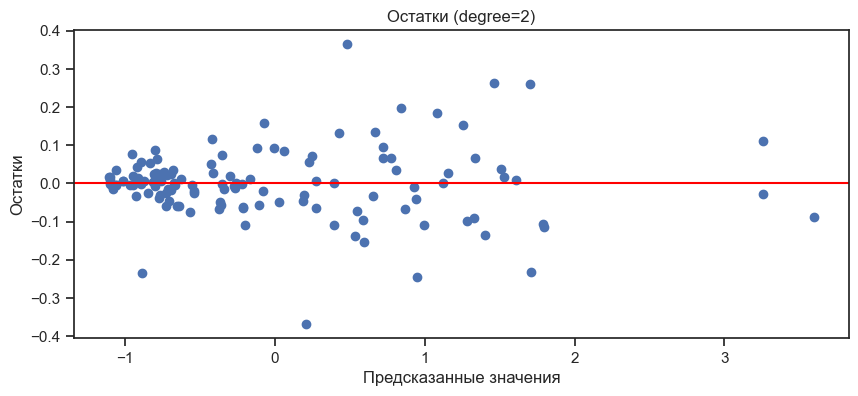


Анализ для степени 3
Исходное количество признаков: 12
После преобразования: 454 признаков

Train R²: 0.9999
Test R²: -223.6744
Train MSE: 0.0001
Test MSE: 250.9572


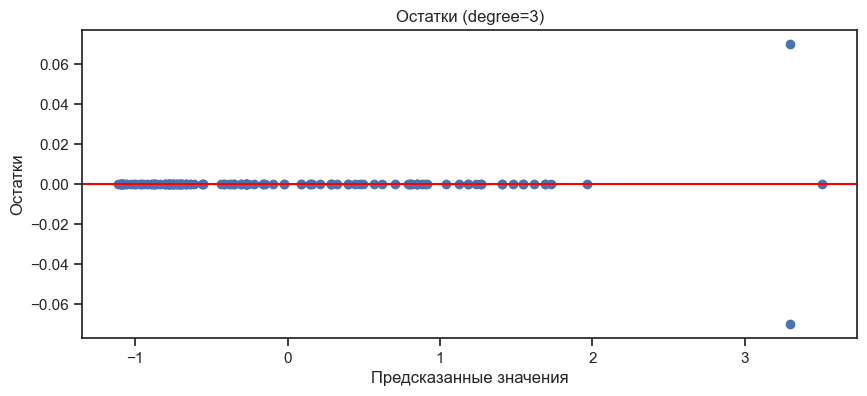


Анализ для степени 4
Исходное количество признаков: 12
После преобразования: 1819 признаков

Train R²: 0.9999
Test R²: -63.8127
Train MSE: 0.0001
Test MSE: 72.3946


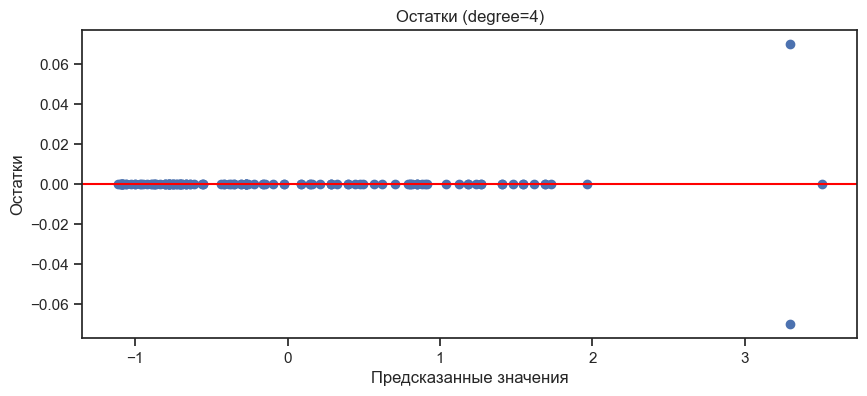

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

degrees = [2, 3, 4]

for degree in degrees:
    print(f"\n{'='*50}")
    print(f"Анализ для степени {degree}")
    print(f"{'='*50}")
    
    try:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('linear', LinearRegression())
        ])
        
        model.fit(X_train, y_train)
        
        print(f"Исходное количество признаков: {X_train.shape[1]}")
        print(f"После преобразования: {model.named_steps['poly'].n_output_features_} признаков")
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        print(f"\nTrain R²: {r2_score(y_train, y_train_pred):.4f}")
        print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
        print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
        print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
        
        residuals = y_train - y_train_pred
        plt.figure(figsize=(10, 4))
        plt.scatter(y_train_pred, residuals)
        plt.axhline(0, color='red')
        plt.title(f'Остатки (degree={degree})')
        plt.xlabel('Предсказанные значения')
        plt.ylabel('Остатки')
        plt.show()
        
    except Exception as e:
        print(f"Ошибка для степени {degree}: {str(e)}")
        continue

**для степени 3 и 4 происходит переобучение, можель просто запоминает точки, поэтому остатков нет**